#**EE452: Computer Vision**
---
## **Assignment 1:** Training Neural Networks for Image Classification

### Student Name: <code>Shifa Shah</code>
### Student ID: <code>08336</code>

## **Assignment Objectives**
To understand the usage of numpy for vectorized coding and perform
preprocessing of dataset.
* To perform feature extraction and apply Support Vector Machine (SVM)
classifier on extracted features.
* To create dense and sparse neural network classifiers from scratch and
apply on CIFAR-10 dataset.
* To perform regularization to improve the trained networks.
* To create neural network classifier using transfer learning (trained on
ImageNet) and apply on CIFAR-10 dataset.
* To perform hyperparameter tuning.

## **READ THESE INSTRUCTIONS FIRST**

* This assignment is an individual task where only collaboration in terms of discussing and idea sharing is allowed.
* This Python notebook (.ipynb) is to be submitted on LMS describing
the different phases of the work including what worked, what did not
work, what you learned, what extra things you tried, etc. A link to the
notebook is not acceptable and would give you a straight 0.

## **Conceptual Questions**

### **Question # 1** ###

**Suppose you have a CNN with three convolutional layers, each with a kernel size of 5×5, a stride of 1, and no padding. If the input image size is 128×128 what will be the output size after these layers? Justify your answer.**

output_size = (((Input - Filter) + 2P )/stride ) +1
            = ((128 - 5) + 2(0) / 1 ) + 1
            = 124 x 124

### **Question # 2** ###

**Compare L1 and L2 regularization in CNNs. Given a dataset with a high number of irrelevant features, which one would be more beneficial and why?**

L1 and L2 regularization are two common techniques used to prevent overfitting in CNNs. L1 regularization sets some feature weights to zero, effectively removing irrelevant features, while L2 regularization reduces the magnitude of all feature weights without making them zero. Unlike L1, L2 does not eliminate features but rather ensures that no single feature dominates. When dealing with a high number of irrelevant features, L1 regularization is beneficial because it eliminates unnecessary features, keeping only the relevant ones, which can improve model accuracy and generalization. However, if some irrelevant features still carry minor useful information, that information will be lost if L1 regularization is used so in that case L2 regularization may be preferred, as it retains all features while controlling their influence.

### **Question # 3** ###

**Assume you trained a CNN on a small dataset and observed a vali-
dation accuracy of 95%, but the test accuracy drops to 60%. What
regularization techniques would you use to mitigate this issue? Justify
your approach.**

The drop in test accuracy suggests overfitting, which means that the CNN has memorized patterns too specific to the validation set and fails to generalize to unseen test data. Following regularization techniques can be applied to mitigate this:
1. Data Augmentation
Introduces variations like rotation, flipping, zooming, cropping, and noise to expand the dataset, helping the model generalize better and reduce dependency on specific patterns in the training set.
2. Dropout
Randomly drops neurons during training to prevent over-reliance on specific features and helps ensure the model generalizes rather than memorizing patterns.
3. Early Stopping
Stops training when validation accuracy continues increasing and test accuracy stops improving and prevents the model from learning noise in the training data.

## **Implementation**

### **Question # 4** ###

**Write a function filt to perform filtering. The function should take
the following arguments: input, filter, padding, normalization.**

**The input is the numpy representation of an image with either one or
three channels, filter is a 2D numpy array, padding is a boolean to de-
termine if the output should match the input size, and normalization
is a boolean to determine if the operation needs normalization. Only
numpy can be used.**

**Apply 3 different filters: Edge Detection Filter, Average Low Pass
Filter and Emboss (3D Effect) Filter, to a sample image using your
created function. Explain what each filter does and how the kernel
design helps in achieving this effect.**

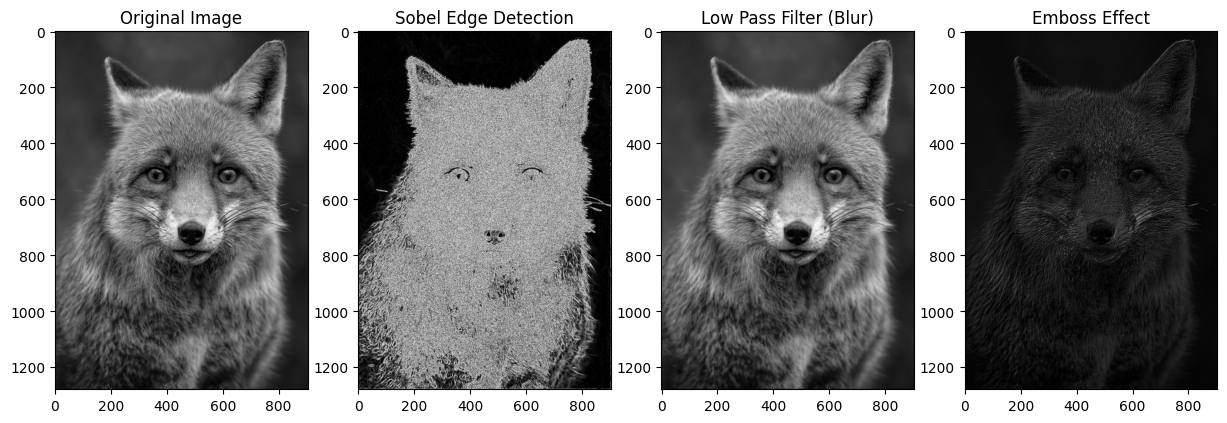

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def filt(input_image, filter_kernel, padding=True, normalization=True):
    img_h, img_w = input_image.shape[:2]
    k_h, k_w = filter_kernel.shape

    # Padding
    pad_h, pad_w = k_h // 2, k_w // 2
    if padding:
        padded_image = np.pad(input_image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
    else:
        padded_image = input_image

    output_h, output_w = (img_h, img_w) if padding else (img_h - 2 * pad_h, img_w - 2 * pad_w)
    output = np.zeros((output_h, output_w))

    for i in range(output_h):
        for j in range(output_w):
            region = padded_image[i:i + k_h, j:j + k_w]
            output[i, j] = np.sum(region * filter_kernel)

    # Normalization
    if normalization:
        output = np.abs(output)
        output = np.clip((output - output.min()) / (output.max() - output.min()) * 255, 0, 255)

    return np.uint8(output)



sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])


low_pass_filter = np.ones((3, 3)) / 9
emboss_filter = np.array([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]])


image = cv2.imread('fox003.jpg', cv2.IMREAD_GRAYSCALE)

Gx = filt(image, sobel_x)
Gy = filt(image, sobel_y)

sobel_final = np.sqrt(Gx**2 + Gy**2)
sobel_final = (sobel_final / sobel_final.max()) * 255
sobel_final = np.uint8(sobel_final)

filtered_lowpass = filt(image, low_pass_filter)
filtered_emboss = filt(image, emboss_filter)


fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")
axes[1].imshow(sobel_final, cmap='gray')
axes[1].set_title("Sobel Edge Detection")
axes[2].imshow(filtered_lowpass, cmap='gray')
axes[2].set_title("Low Pass Filter (Blur)")
axes[3].imshow(filtered_emboss, cmap='gray')
axes[3].set_title("Emboss Effect")

plt.show()

### **Question # 5** ###

**Load the Intel Image Classification Dataset and briefly describe what the dataset is about and its constituents. You can view the documentation for Intel Image Classification dataset. Also mention some preprocessing steps that can be applied while dealing with image data in general.**

**Extract HOG features from the Intel Image Classification dataset and train a Linear SVM using those features.**

The Intel Image Classification Dataset is a collection of approximately 25000 images, each sized at 150x150 pixels, categorized into six distinct classes: Buildings, Forest, Glacier, Mountain, Sea, Street.
These images are organized into training, testing, and prediction sets, with around 14000 images for training, 3000 for testing, and 7000 for prediction.
Preprocessing Steps for Image Data: <br>
1) Resizing: Ensure all images are of uniform dimensions to maintain consistency across the dataset.<br>
2) Normalization: Scale pixel values, typically to a range of [0, 1], to facilitate faster convergence during training.<br>
3) Data Augmentation: Apply transformations like rotations, flips, and shifts to artificially expand the dataset and improve model robustness.<br>
4) Grayscale Conversion: For certain applications, converting images to grayscale can simplify computations without significant loss of information.

In [13]:
import zipfile
import os

zip_file_path = "archive.zip"
extract_path = "dataset"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

Files extracted to: dataset


In [14]:
folders = os.listdir(extract_path)
print("Extracted folders:", folders)

Extracted folders: ['seg_pred', 'seg_train', 'seg_test']


Loaded 14034 training images and 3000 test images and 7301 prediction images.
Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


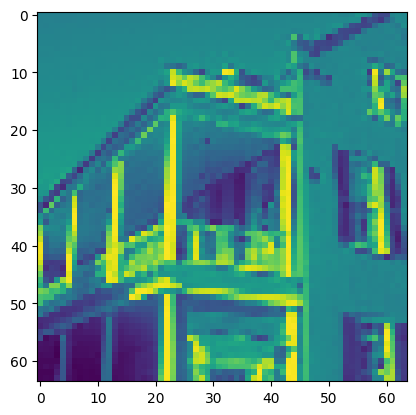

In [15]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from skimage import color
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report,accuracy_score

train_path = "dataset/seg_train/seg_train"
test_path = "dataset/seg_test/seg_test"
pred_path = "dataset/seg_pred/seg_pred"

def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = []

    if any(os.path.isdir(os.path.join(folder, item)) for item in os.listdir(folder)):
        class_names = sorted([d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))])

        for label, class_name in enumerate(class_names):
            class_folder = os.path.join(folder, class_name)

            for file in os.listdir(class_folder):
                img_path = os.path.join(class_folder, file)
                if not os.path.exists(img_path):
                    print(f"Missing: {img_path}")
                    continue
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Failed to load: {img_path}")
                    continue
                img = cv2.resize(img, (64, 64))
                images.append(img)
                labels.append(label)
    else:
        class_names = ["Unlabeled"]
        for file in os.listdir(folder):
            img_path = os.path.join(folder, file)
            if not os.path.exists(img_path):
                print(f"Missing: {img_path}")
                continue
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Failed to load: {img_path}")
                continue
            img = cv2.resize(img, (64, 64))
            images.append(img)
            labels.append(0)

    return np.array(images), np.array(labels), class_names


X_train, y_train, class_names = load_images_from_folder(train_path)
X_test, y_test, _ = load_images_from_folder(test_path)
X_pred, _,_ = load_images_from_folder(pred_path)

print(f"Loaded {len(X_train)} training images and {len(X_test)} test images and {len(X_pred)} prediction images.")
print("Class names:", class_names)

plt.imshow(X_train[51])

In [19]:
def extract_hog_features(images):
    hog_features = []
    for image in images:
        fd = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                 block_norm='L2', visualize=False)
        hog_features.append(fd)
    return np.array(hog_features)

X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

In [20]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from cuml.svm import LinearSVC


pca = PCA(n_components=500)
X_train_pca = pca.fit_transform(X_train_hog)
X_test_pca = pca.transform(X_test_hog)


param_grid = {"C": [0.01, 0.1, 1, 10, 100, 500]}

grid = GridSearchCV(LinearSVC(), param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
grid.fit(X_train_pca, y_train)

best_svm = grid.best_estimator_
print(f"Best Params: {grid.best_params_}")

y_pred = best_svm.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Params: {'C': 0.01}
Test Accuracy: 66.77%
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       437
           1       0.78      0.92      0.84       474
           2       0.61      0.57      0.59       553
           3       0.53      0.55      0.54       525
           4       0.60      0.61      0.61       510
           5       0.77      0.70      0.73       501

    accuracy                           0.67      3000
   macro avg       0.67      0.67      0.67      3000
weighted avg       0.67      0.67      0.67      3000



### **Question # 6** ###

**This part requires you to use only pytorch. In each of the following subparts (a, b, and c) you are required to do the following:**
* **Create a network architecture.**
* **Load the Fashion MNIST dataset.**
* **Preprocess the dataset accordingly.**
* **Train your architecture on the dataset for a reasonable number of epochs (maximum is 100) using the testing data as your validation data.**
* **Report both your training accuracy as well as validation accuracy.**
* **Plot both the training loss as well as the validation loss on the same plot.**
* **Plot both the training accuracy as well as the validation accuracy on the same plot.**

**For each subpart you are encouraged to experiment both with the hyperparameters as well as different architecture designs for your network.**

#### **Part (a)** ###

**Create a feed-forward neural network with at least two hidden layers, experiment with regularization, and achieve above 90% test accuracy.**

Epoch [1/80], Train Loss: 0.4497, Train Acc: 84.09%, Val Loss: 0.3740, Val Acc: 85.95%
Epoch [6/80], Train Loss: 0.2481, Train Acc: 90.74%, Val Loss: 0.3149, Val Acc: 88.46%
Epoch [11/80], Train Loss: 0.2036, Train Acc: 92.34%, Val Loss: 0.3055, Val Acc: 89.53%
Epoch [16/80], Train Loss: 0.1687, Train Acc: 93.70%, Val Loss: 0.3191, Val Acc: 89.40%
Epoch [21/80], Train Loss: 0.1477, Train Acc: 94.48%, Val Loss: 0.3201, Val Acc: 89.91%
Epoch [26/80], Train Loss: 0.1303, Train Acc: 95.13%, Val Loss: 0.3359, Val Acc: 89.69%
Epoch [31/80], Train Loss: 0.1196, Train Acc: 95.49%, Val Loss: 0.3425, Val Acc: 89.49%
Epoch [36/80], Train Loss: 0.1110, Train Acc: 95.75%, Val Loss: 0.3748, Val Acc: 89.05%
Achieved 90% validation accuracy


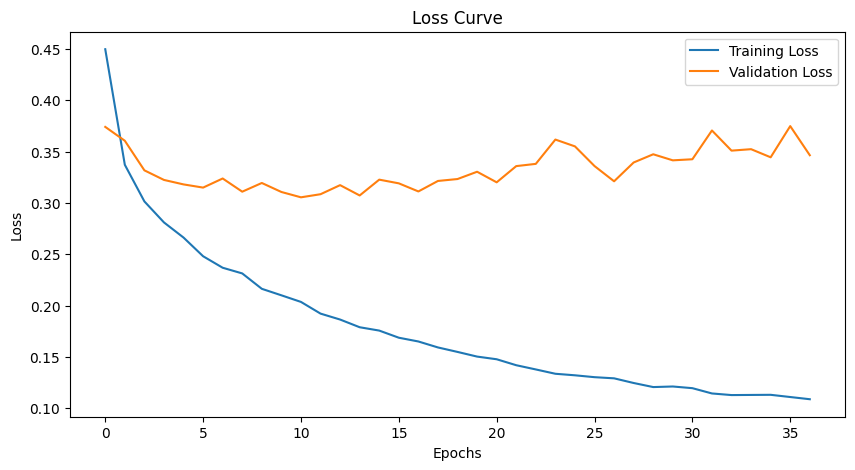

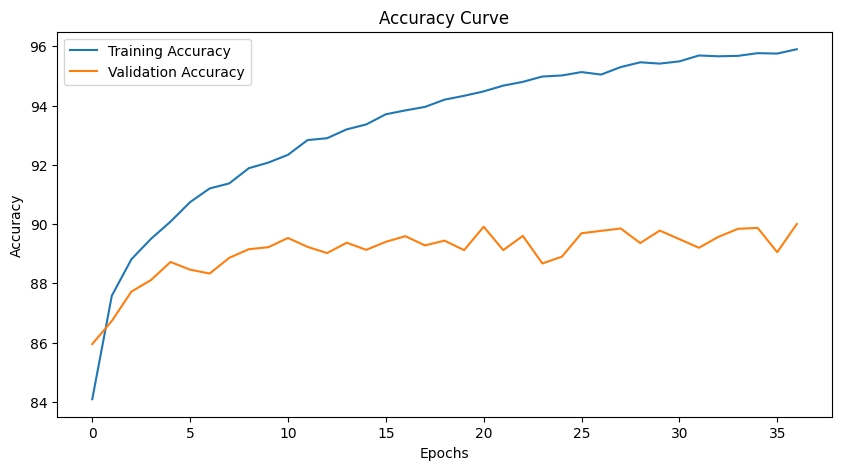

Final Training Accuracy: 95.90%
Final Validation Accuracy: 90.00%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


input_size = 28 * 28
hidden_size1 = 512
hidden_size2 = 256
num_classes = 10
num_epochs = 80
batch_size = 128
learning_rate = 0.0008
weight_decay = 1e-4  # L2 Regularization

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = x.view(-1, input_size)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


model = FeedForwardNN(input_size, hidden_size1, hidden_size2, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
final_train_acc, final_val_acc = 0, 0

for epoch in range(num_epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)


    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)


    final_train_acc = train_acc
    final_val_acc = val_acc

    if epoch % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    if val_acc >= 90:
        print("Achieved 90% validation accuracy")
        break


plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

print(f"Final Training Accuracy: {final_train_acc:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")


#### **Part (b)** ###

**Create a convolutional neural network with at least two convolutional layers, experiment with regularization, and achieve above 92% test accuracy.**

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 67ms/step - accuracy: 0.6133 - loss: 1.2925 - val_accuracy: 0.4088 - val_loss: 1.8171 - learning_rate: 0.0010
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.8067 - loss: 0.6336 - val_accuracy: 0.8345 - val_loss: 0.5329 - learning_rate: 0.0010
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.8350 - loss: 0.5259 - val_accuracy: 0.8641 - val_loss: 0.4381 - learning_rate: 0.0010
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.8544 - loss: 0.4557 - val_accuracy: 0.8280 - val_loss: 0.4816 - learning_rate: 0.0010
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.8619 - loss: 0.4117 - val_accuracy: 0.8549 - val_loss: 0.4253 - learning_rate: 0.0010
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.8708 - loss: 0.3896 - val_accuracy: 0.8805 - val_loss: 0.3538 - learning_rate: 0.0010
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.8785 - l

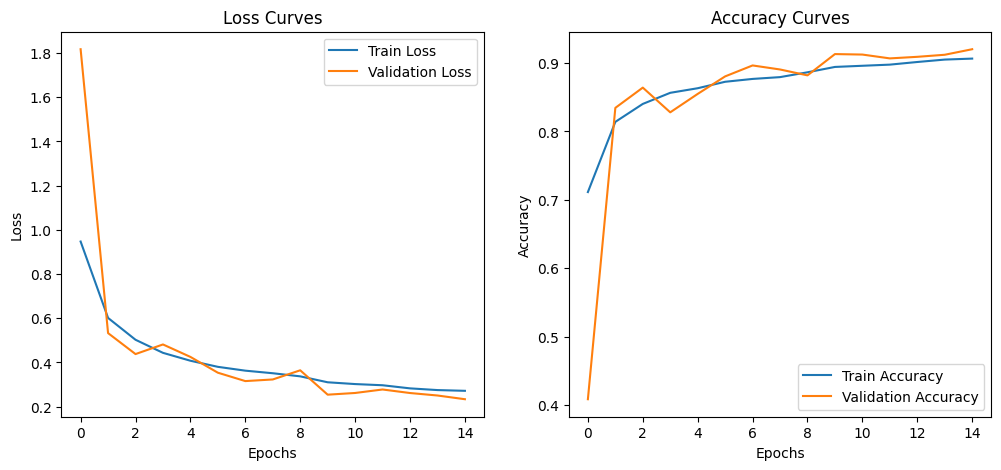

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9239 - loss: 0.2278
Final Test Accuracy: 0.9202


In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau


(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0


train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)


datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(train_images)

def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding="same", input_shape=(28,28,1)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3,3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3,3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model



class StopTrainingAtAccuracy(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') and logs['val_accuracy'] > 0.92:
            print(f"\nStopping training: Validation accuracy reached {logs['val_accuracy']:.4f}")
            self.model.stop_training = True


lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)


model = create_model()

history = model.fit(datagen.flow(train_images, train_labels, batch_size=128),
                    epochs=30,
                    validation_data=(test_images, test_labels),
                    callbacks=[StopTrainingAtAccuracy(), lr_scheduler])


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Final Test Accuracy: {test_acc:.4f}')


#### **Part (c)** ###

**Use the pre-trained VGG-16 network (trained on ImageNet) as a feature extractor, connect it to a feed-forward network, fine-tune it, and achieve above 85% test accuracy.**

Epoch 1: Train Loss: 0.2762, Train Acc: 89.98%, Val Loss: 0.2373, Val Acc: 91.57%
Epoch 2: Train Loss: 0.1590, Train Acc: 94.09%, Val Loss: 0.2289, Val Acc: 91.83%
Epoch 3: Train Loss: 0.1139, Train Acc: 95.72%, Val Loss: 0.2621, Val Acc: 91.80%
Test Accuracy: 91.80%


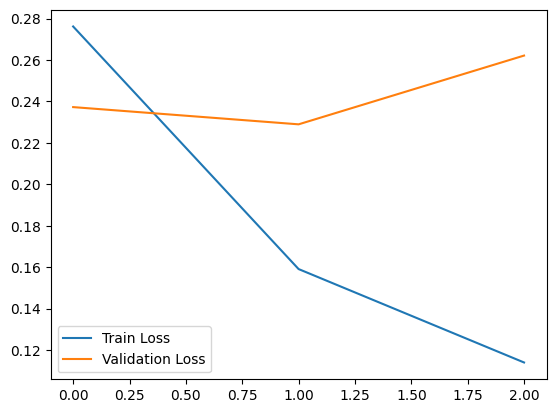

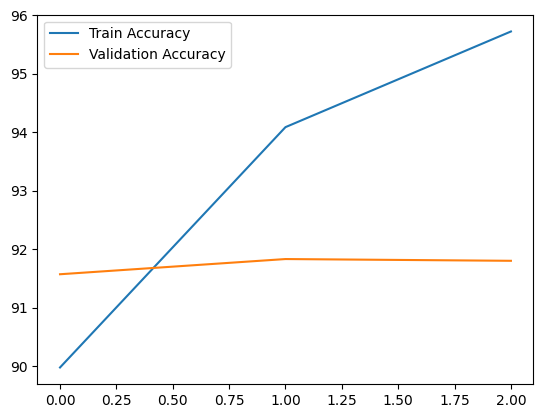

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


train_loader = DataLoader(datasets.FashionMNIST('data', train=True, transform=transform, download=True), batch_size=64, shuffle=True)
test_loader = DataLoader(datasets.FashionMNIST('data', train=False, transform=transform, download=True), batch_size=64, shuffle=False)

model = models.vgg16(weights='DEFAULT')
for param in model.features.parameters():
    param.requires_grad = False
model.classifier = nn.Sequential(
    nn.Linear(25088, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

train_losses, val_losses, train_accs, val_accs = [], [], [], []
for epoch in range(3):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(correct / len(train_loader.dataset) * 100)

    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            correct += (outputs.argmax(1) == labels).sum().item()

    val_losses.append(val_loss / len(test_loader))
    val_accs.append(correct / len(test_loader.dataset) * 100)

    print(f"Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.2f}%")


correct = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        correct += (model(images).argmax(1) == labels).sum().item()
print(f"Test Accuracy: {correct / len(test_loader.dataset) * 100:.2f}%")


plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.legend()
plt.show()
